In [97]:
import scanpy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import muon
import mofax


In [98]:
# pbmc = scanpy.read_10x_h5('5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5', gex_only=False)
pbmc = scanpy.read('data.h5ad', gex_only=False)
pbmc.var_names_make_unique()
# pbmc.layers['counts'] = pbmc.X.copy()
# scanpy.pp.filter_genes(pbmc, min_counts=1)


In [100]:
pbmc = pbmc[:1000, :]
pbmc


View of AnnData object with n_obs × n_vars = 1000 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'

In [107]:
# print(pbmc.var['feature_types'].value_counts())
print(pbmc)

data_gene = pbmc[:, pbmc.var['feature_types'] == 'GEX']
data_prot = pbmc[:, pbmc.var['feature_types'] == 'ADT']

mdata = muon.MuData(dict(
  gene_expr=data_gene,
  prot_expr=data_prot
))

mdata


View of AnnData object with n_obs × n_vars = 1000 × 14087
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
    var: 'feature_types', 'gene_id'
    uns: 'dataset_id', 'genome', 'organism'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
    layers: 'counts'


MuData object with n_obs × n_vars = 1000 × 14087
  var:	'feature_types', 'gene_id'
  2 modalities
    gene_expr:	1000 x 13953
      obs:	'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
      var:	'feature_types', 'gene_id'
      uns:	'dataset_id', 'genome', 'organism'
      obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
      layers:	'counts'
    prot_expr:	1000 x 134
      obs:	'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train'
      var:	'feature_types', 'gene_id'
      uns:	'dataset_id', 'genome', 'organism'
      obsm:	'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap'
      layers:	'counts'

## MOFA

In [50]:
muon.tl.mofa(mdata, outfile='result.hdf5', save_data=False, save_metadata=False)



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='gene_expr' group='group1' with N=1000 samples and D=134 features...
Loaded view='prot_expr' group='group1' with N=1000 samples and D=13953 features...



Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on th

In [51]:
model = mofax.mofa_model('result.hdf5')


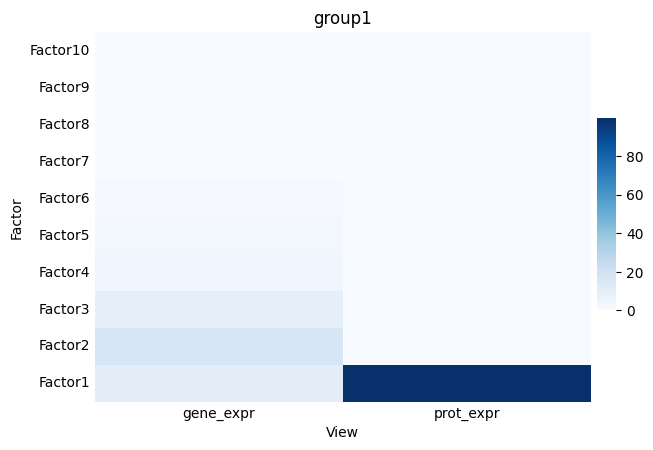

In [96]:
mofax.plot_r2(model, x='View')


<Axes: title={'center': 'group'}, xlabel='Factor1', ylabel='Factor2'>

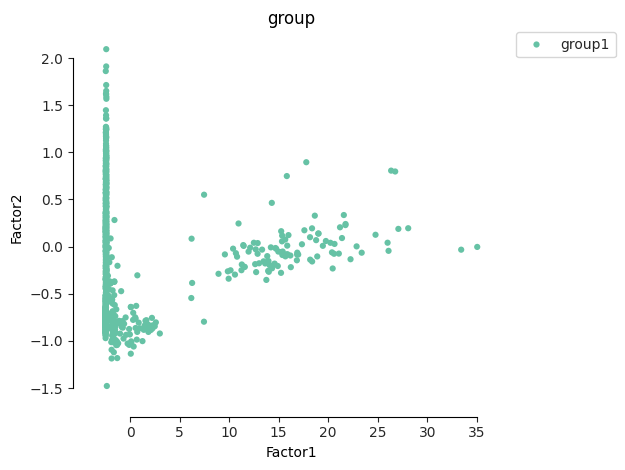

In [53]:
mofax.plot_factors(model, x = "Factor1", y="Factor2",  size=20)


## Pyro

In [102]:
import pyro
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO, autoguide
import pyro.distributions
import torch
# from torch.nn.functional import softplus
# from sklearn.metrics import mean_squared_error
from anndata import AnnData
from tqdm import tqdm


In [91]:

class FA(PyroModule):
  def __init__(self, data, latent_count: int):
    super().__init__()
    pyro.clear_param_store()

    self.data = torch.as_tensor(data) # Samples x Variables
    self.latent_count = latent_count

    self.sample_count = self.data.shape[0]
    self.feature_count = self.data.shape[1]

    self.sample_plate = pyro.plate('sample', self.sample_count)
    self.feature_plate = pyro.plate('feature', self.feature_count)
    self.latent_factor_plate = pyro.plate('latent factors', self.latent_count)

  def model(self):
    with self.latent_factor_plate:
      eps = pyro.sample('eps', pyro.distributions.Normal())

      with self.feature_plate:
        W = pyro.sample('W', pyro.distributions.Normal(0., 1.))

      with self.sample_plate:
        Z = pyro.sample('Z', pyro.distributions.Normal(0., 1.))

    Y_hat = torch.matmul(Z, W.t())

    with pyro.plate('feature_', self.feature_count), pyro.plate('sample_', self.data.shape[0]):
      # obs_mask = torch.ones_like(self.data, dtype=torch.bool)
      # obs_mask = torch.logical_not(torch.isnan(self.data))

      # with pyro.poutine.mask(mask=obs_mask):
      #   filled_data = torch.nan_to_num(self.data, nan=0)

      scale = pyro.sample('scale', pyro.distributions.LogNormal(0., 1.))
      pyro.sample('obs', pyro.distributions.Normal(Y_hat, scale), obs=self.data)


def train(fa: FA):
  optimizer = pyro.optim.Adam({"lr": 0.02})
  elbo = Trace_ELBO()
  guide = autoguide.AutoDelta(fa.model)

  svi=SVI(
    model=fa.model,
    guide=guide,
    optim=optimizer,
    loss=elbo
  )

  epoch_count = 100
  train_losses = np.empty(epoch_count)

  for epoch_index in tqdm(list(range(epoch_count))):
    loss = svi.step()
    train_losses[epoch_index] = loss / fa.data.shape[0]

  map_estimates = guide(fa.data)
  return train_losses, map_estimates


In [116]:
# fa_gene = FA(data_gene.X.toarray(), latent_count=10)
fa_prot = FA(data_prot.X.toarray(), latent_count=10)


In [117]:
pbmc.X
# fa = FA(pbmc.X.toarray(), 10)
losses, result = train(fa_prot)


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 113.93it/s]


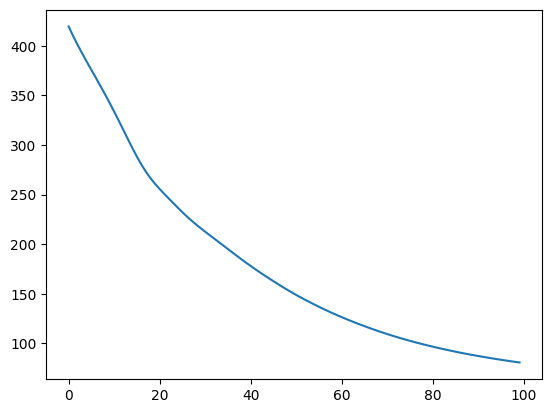

In [118]:
fig, ax = plt.subplots()

ax.plot(losses)


torch.Size([134, 10])


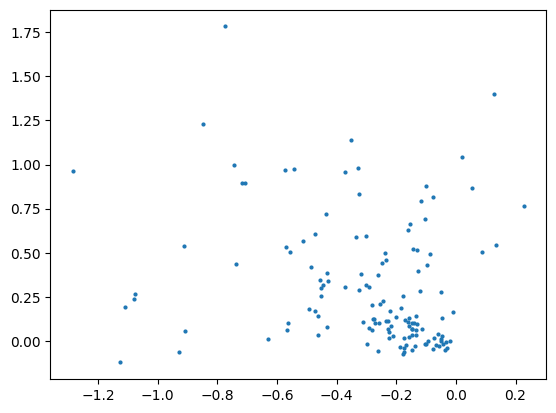

In [119]:
latent = result['W'].detach()
print(latent.size())

fig, ax = plt.subplots()

ax.scatter(latent[:, 0], latent[:, 1], s=4.0)
